In [165]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import scipy.interpolate as sci
%matplotlib inline

### The basic idea of MPT is diversification to achieve a minimal portfolio risk or maximal portfolio returns

In [32]:
symbols = ['AAPL', 'MSFT', 'DB', 'GLD']

In [33]:
data = pd.DataFrame()

In [34]:
symbols = ['AAPL','MSFT','DB','GLD']  # we donot have yahoo anymore
noa = len(symbols)
data= pd.DataFrame()

#df = web.DataReader(symbols, data_source="yahoo", )
for sym in symbols: 
    data[sym] = web.DataReader(sym, data_source='yahoo')['Adj Close']
data.columns = symbols

In [65]:
data.head()

,AAPL,MSFT,DB,GLD
Date,,,,
2014-09-25,89.805222,41.213509,32.846149,117.389999
2014-09-26,92.447876,41.544716,33.155479,117.059998
2014-09-29,91.860641,41.571568,32.705540,117.029999
2014-09-30,92.447876,41.499958,32.677418,116.209999
2014-10-01,91.007271,41.088188,32.639919,116.769997


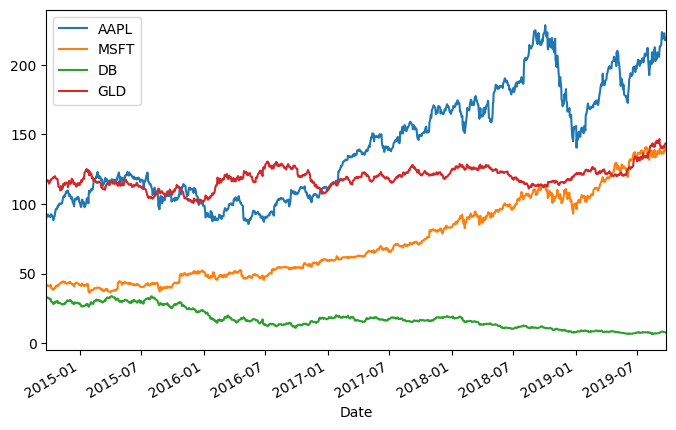

In [113]:
data.plot(figsize = (8.,5))

### Normalize the data

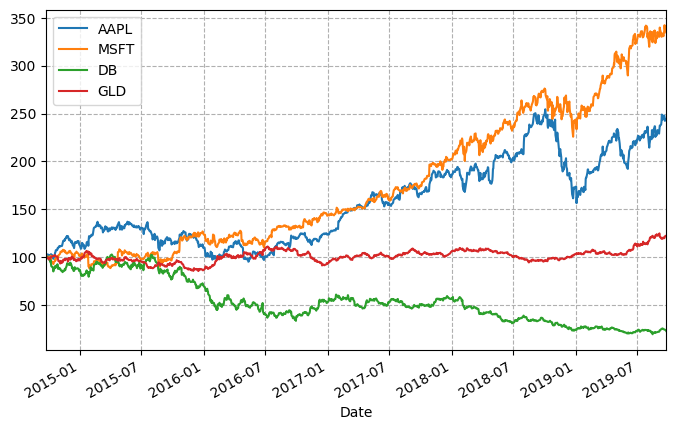

In [70]:
plt.style.use('default')
ax1 = (data/data.iloc[0] * 100).plot(figsize = (8,5))
ax1.xaxis.grid(True, which = 'major', linestyle='--')
ax1.yaxis.grid(True, which = 'major', linestyle='--')

### Mean-variance refers to the mean and variance of the log return

In [71]:
rets = np.log(data/data.shift(1))

In [67]:
rets.mean() * 252

AAPL    0.179077
MSFT    0.242244
DB     -0.293964
GLD     0.040821
dtype: float64

In [75]:
rets.cov()*252

,AAPL,MSFT,DB,GLD
AAPL,0.062313,0.033714,0.028053,-0.003808
MSFT,0.033714,0.055373,0.029053,-0.003533
DB,0.028053,0.029053,0.145664,-0.009222
GLD,-0.003808,-0.003533,-0.009222,0.017212


In [107]:
weights = np.random.random(4)

In [108]:
weights /= np.sum(weights)

In [109]:
weights

array([0.44946414, 0.15356362, 0.08947322, 0.30749902])

### Expected portfolio return

In [110]:
np.sum(rets.mean() * weights) * 252

0.10393889417172297

### Expected portfolio variance

In [111]:
np.dot(weights.T, np.dot(rets.cov()*252, weights))

0.022502508064689966

In [112]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov()*252, weights)))

0.15000835998266884

### Monte Carlo simulation

In [114]:
prets = []
pvols = []

for p in range(2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T,
                               np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

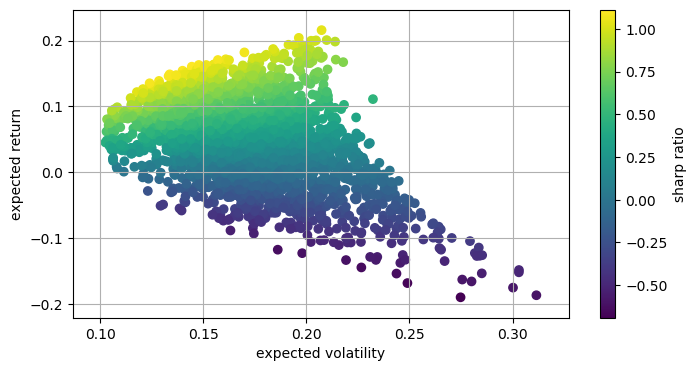

In [116]:
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='sharp ratio')

## Portfolio optimization

In [117]:
def statistics(weights):
    """
    weights: array-like
    """
    
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov()*252, weights)))
    return np.array([pret, pvol, pret/pvol])

### Target function

In [119]:
import scipy.optimize as sco
def min_func_sharp(weights):
    return -statistics(weights)[2]

### Constraints

In [120]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

### Boundary

In [121]:
bnds = tuple((0,1) for x in range(noa))

In [122]:
noa * [1./noa]

[0.25, 0.25, 0.25, 0.25]

### optimization function

In [124]:
opts = sco.minimize(min_func_sharp, noa * [1./noa,], method='SLSQP', bounds=bnds, constraints=cons)

In [125]:
opts

     fun: -1.1310309270376844
     jac: array([ 3.10763717e-04,  6.99236989e-04,  2.98675291e+00, -9.16391611e-04])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.10675495, 0.48546838, 0.        , 0.40777667])

In [126]:
opts['x'].round(3)

array([0.107, 0.485, 0.   , 0.408])

In [127]:
statistics(opts['x']).round(3)

array([0.153, 0.136, 1.131])

In [128]:
def min_func_variance(weights):
    return statistics(weights)[1]**2

In [129]:
optv = sco.minimize(min_func_variance, noa*[1./noa,], method='SLSQP', bounds = bnds, constraints=cons)

In [130]:
optv

     fun: 0.010420851515579165
     jac: array([0.02030988, 0.0208711 , 0.02049775, 0.02094941])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.10309312, 0.1358358 , 0.06848548, 0.6925856 ])

In [131]:
optv['x'].round(3)

array([0.103, 0.136, 0.068, 0.693])

In [133]:
statistics(optv['x']).round(3)

array([0.06 , 0.102, 0.583])

## Efficient Frontier

In [134]:
cons = (
    {'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bnds = tuple((0,1) for x in weights)

In [135]:
def min_func_port(weights):
    return statistics(weights)[1]

In [138]:
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = (
    {'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa*[1. / noa], method='SLSQP',
                      bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

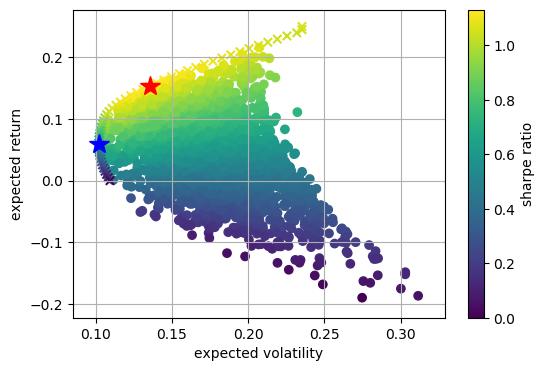

In [144]:
plt.figure(figsize=(6,4))
plt.scatter(pvols, prets,
           c=prets/pvols, marker='o')

# random portfolio composition
plt.scatter(tvols, trets,
           c=trets/tvols, marker='x')

# efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
        'r*', markersize=15.0)

# portfolio with highest sharp ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 
        'b*', markersize=15.0)
# minimum variance portfolio

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='sharpe ratio')

## Capital Market Line

In [159]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [164]:
tck = scipy.interpolate.splrep(evols, erets)

In [166]:
def f(x):
    """
    efficient frontier function
    """
    return sci.splev(x, tck, der=0)

def df(x):
    return sci.splev(x, tck, der=1)

In [168]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1]*p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [169]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

In [170]:
opt

array([1.00000000e-02, 2.18363279e+01, 1.47832277e-01])

In [171]:
np.round(equations(opt), 6)

array([ 0.e+00, -0.e+00, -1.e-06])

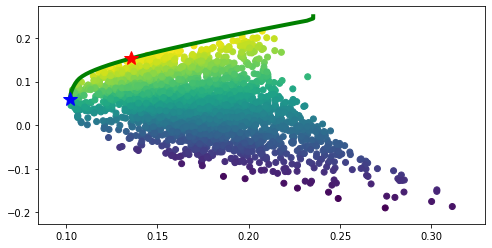

In [189]:
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets,
           c=(prets-0.01)/pvols, marker='o')
#original data
plt.plot(evols, erets, 'g', lw=4.0)
# the optimal data

# cx = np.linspace(0.0, 0.3, 10)
# plt.plot(cx, opt[0] + opt[1] * cx, lw = 1.5)

# plt.plot(opt[2], f(opt[2]), 'r*', markersize = 15.6)

plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
        'r*', markersize=15.0)

# portfolio with highest sharp ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 
        'b*', markersize=15.0)

In [180]:
cx

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ])

In [181]:
opt[0] + opt[1] * cx

array([0.01      , 0.7378776 , 1.46575519, 2.19363279, 2.92151039,
       3.64938799, 4.37726558, 5.10514318, 5.83302078, 6.56089837])

In [182]:
opt[0]

0.01

In [183]:
opt[1]

21.836327915253175

In [184]:
cons = (
{'type': 'eq', 'fun': lambda x: statistics(x)[0]- f(opt[2])},
{'type': 'eq', 'fun': lambda x: np.sum(x) -1})

res = sco.minimize(min_func_port, noa*[1./noa,], method='SLSQP',
                  bounds=bnds, constraints=cons)

In [185]:
res['x'].round(3)

array([0., 1., 0., 0.])